## Python class vs custom scikit transformer

Example with IQR outlier removal

Generate sine data

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [91]:
cycles = 2 # how many sine cycles
resolution = 25 # how many datapoints to generate
adhere_lower_part_to_sin = 0.2

length = np.pi * 2 * cycles
my_wave_sin = np.sin(np.arange(0, length, length / resolution))
noise = np.random.normal(0, np.std(my_wave_sin)*10, 5)
noise = np.append(noise, np.random.normal(0, np.std(my_wave_sin)*adhere_lower_part_to_sin, len(my_wave_sin)-5))

my_wave = my_wave_sin+noise

my_wave_sin = pd.DataFrame(my_wave_sin).reset_index()
my_wave_sin.columns=['time', 'vib']

wavedf = pd.DataFrame(my_wave).reset_index()
wavedf.columns=['time', 'vib']

Text(0.5, 1.0, 'Unfiltered sine wave (green) and with noise (black)')

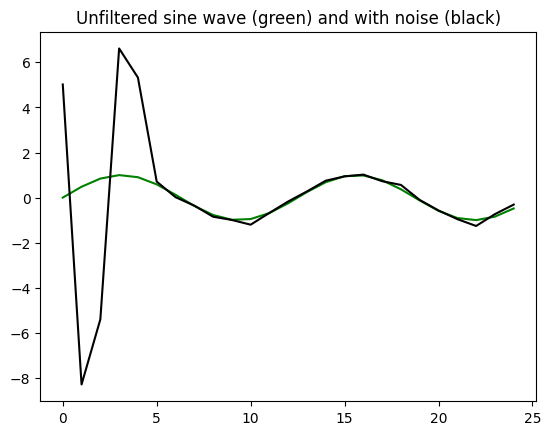

In [92]:
plt.plot(my_wave_sin['time'], my_wave_sin['vib'], 'g')
plt.plot(wavedf['time'], wavedf['vib'], 'k')
plt.title('Unfiltered sine wave (green) and with noise (black)')


Noise is added to the first 5 samples of the data, enlarging it 10x. The rest of the cusrve has just a bit of noise added, almost resembling the sine curve. The reason we do it like that is to have the front of the curve considered outliers by the algorythm and to be chopped off

Python class

In [93]:


class pythonIQROutlier:
    """
    Outlier removal using Inter-quartile range.
    Will calculate q3 (75th) and q1 (25th) percentiles, and IQR = q3-q1.
    Then will remove data above 1.5*IQR+q3 and below q1 - 1.5*IQR.
    Factor 1.5 can be modified to go all the way to 3, depending on how much 
    data should be considered ourliers and removed

    """

    def __init__(self, df: pd.DataFrame, col_name: str, iqr_threshold:float = 1.5, lowerq:int = 25, upperq:int = 75):
        """
        Outlier removal using Inter-quartile range.
        Params:
            df = dataframe with data
            col_name = column in df, needs to be numeric
            iqr_threshold, lowerq, upperq = numeric constants for IQR filtering
        """
        self.df = df.copy()
        self.col_name = col_name
        self.iqr_threshold = iqr_threshold
        self.lowerq = lowerq
        self.upperq = upperq

    def calc_outliers(self):
        """
        Calculation of outliers based on the specified column.
        Returns:
            self
        """
        self.Q1, self.Q3 = np.percentile(self.df[self.col_name], [self.lowerq, self.upperq])
        self.IQR = self.Q3-self.Q1
        self.lower = self.Q1 - self.iqr_threshold*self.IQR
        self.upper = self.Q3 + self.iqr_threshold*self.IQR
        return self

    def filter_data(self):
        """
        Removal of outliers in the whole dataframe

        Returns:
            dataframe
        """
        mask = (self.df[self.col_name] < self.upper) & (self.df[self.col_name] > self.lower)
        return self.df[mask]

Usage

Upper bound: 3.09 
 Lower bound: 3.09


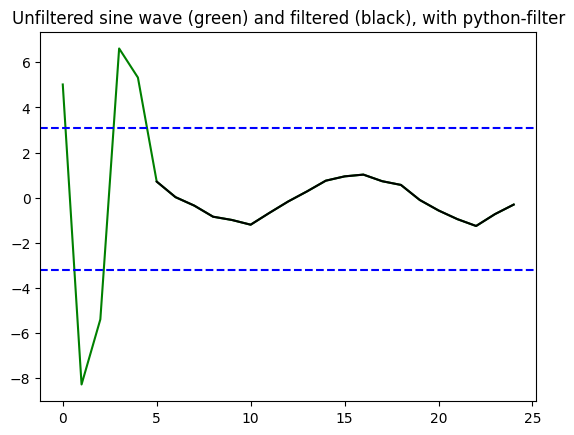

In [110]:
outlier_filt = pythonIQROutlier(wavedf, 'vib')
wavedf_filt = outlier_filt.calc_outliers().filter_data()


import matplotlib.pyplot as plt
plt.plot(wavedf['time'], wavedf['vib'], 'g')
plt.plot(wavedf_filt['time'], wavedf_filt['vib'], 'k')
plt.axhline(outlier_filt.upper, color='b', linestyle='--')
plt.axhline(outlier_filt.lower, color='b', linestyle='--')
plt.title('Unfiltered sine wave (green) and filtered (black), with python-filter')
print(f'Upper bound: {outlier_filt.upper.round(3)} \n Lower bound: {outlier_filt.upper.round(3)}')


The front portion of the original curve (in green) is completly chopped off by IQR filter (filter bounds in blue). What's left is in black - and it lies just between the blue lines

Now with scikit custom Transformer

In [95]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin


class scikitIQROutlier(BaseEstimator, TransformerMixin):
    """
    Outlier removal using Inter-quartile range.
    Will calculate q3 (75th) and q1 (25th) percentiles, and IQR = q3-q1.
    Then will remove data above 1.5*IQR+q3 and below q1 - 1.5*IQR.
    Factor 1.5 can be modified to go all the way to 3, depending on how much 
    data should be considered ourliers and removed

    """

    def __init__(self, col_name:str, iqr_threshold:float = 1.5, lowerq:int = 25, upperq:int = 75):
        """
        Outlier removal using Inter-quartile range.
        Params:
            col_name = column in df, needs to be numeric
            iqr_threshold, lowerq, upperq = numeric constants for IQR filtering
        """
        self.col_name= col_name
        self.iqr_threshold = iqr_threshold
        self.lowerq = lowerq
        self.upperq = upperq

    def fit(self, X, y=None):
        """
        Calculation of outliers based on the specified column.
        Returns:
            self
        """
        self.Q1, self.Q3 = np.percentile(X[self.col_name], [self.lowerq, self.upperq])
        self.IQR = self.Q3-self.Q1
        self.lower = self.Q1 - self.iqr_threshold*self.IQR
        self.upper = self.Q3 + self.iqr_threshold*self.IQR
        return self

    def transform(self, X, y=None):
        """
        Removal of outliers in the whole dataframe

        Returns:
            dataframe
        """
        mask = (X[self.col_name] < self.upper) & (X[self.col_name] > self.lower)
        return X[mask]

Usage - same thing as before

Upper bound: 3.09 
 Lower bound: 3.09


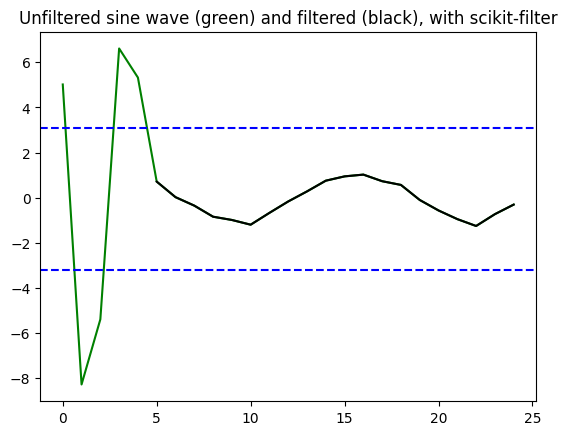

In [112]:
scikit_outlier_filt = scikitIQROutlier(col_name='vib')
wavedf_filt = scikit_outlier_filt.fit_transform(wavedf)

plt.plot(wavedf['time'], wavedf['vib'], 'g')
plt.plot(wavedf_filt['time'], wavedf_filt['vib'], 'k')
plt.axhline(scikit_outlier_filt.upper, color='b', linestyle='--')
plt.axhline(scikit_outlier_filt.lower, color='b', linestyle='--')
plt.title('Unfiltered sine wave (green) and filtered (black), with scikit-filter')
print(f'Upper bound: {scikit_outlier_filt.upper.round(3)} \n Lower bound: {scikit_outlier_filt.upper.round(3)}')

With scikit-transformer, result is exactly the same as with a python-class-based filter

Now, we'll generate a clean sine wave and enlarge it 10x with respect to the original wave. Then we'll .transform() scikit-transformer to it, keeping the same fit as before. In essense, we've created a test/inference set and are checking that it'll keep it's prior fit (i.e. prior upper and lower bounds)

Upper bound: 3.09 
 Lower bound: 3.09


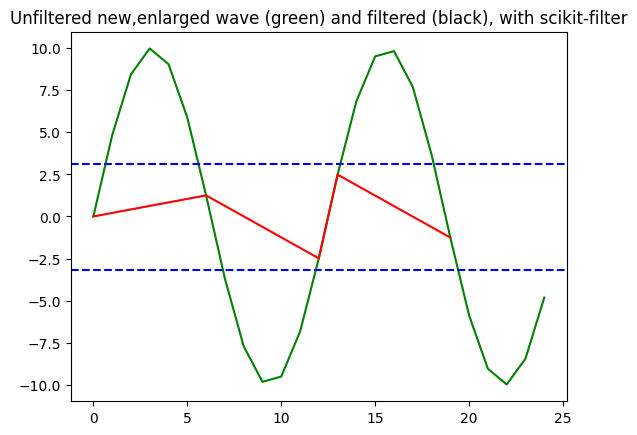

In [111]:
cycles = 2 # how many sine cycles
resolution = 25 # how many datapoints to generate

length = np.pi * 2 * cycles
my_wave = np.sin(np.arange(0, length, length / resolution))*10   # move the wave center down to zero
wavedf_large = pd.DataFrame(my_wave).reset_index()
wavedf_large.columns=['time', 'vib']

wavedf_large_filt = scikit_outlier_filt.transform(wavedf_large)

plt.plot(wavedf_large['time'], wavedf_large['vib'], 'g')
plt.plot(wavedf_large_filt['time'], wavedf_large_filt['vib'], 'r')
plt.axhline(scikit_outlier_filt.upper, color='b', linestyle='--')
plt.axhline(scikit_outlier_filt.lower, color='b', linestyle='--')
plt.title('Unfiltered new,enlarged wave (green) and filtered (black), with scikit-filter')
print(f'Upper bound: {scikit_outlier_filt.upper.round(3)} \n Lower bound: {scikit_outlier_filt.upper.round(3)}')


Upper bound: 3.09 
 Lower bound: 3.09


We have created a sine function 10x the size of the original one and run .transform on it, aiming to see if it was refitted or not.
Since we kept upper and lower bounds the same (at +/-3.09), we have not refitted our transformer.

This would not be possible with the current python filter, since the method  filter_data() only accepts it's class instance - i.e. it can only transform what ot fits on. Modyfying it to work correctly would be essentially the same as writing a custom scikit-transformer, but without the benefit of being able to work with other scikit custim objects - pipleines, cross-validation etc
